In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [2]:
file = 'data/salesdaily.csv'
df = pd.read_csv(file)

In [3]:
df.shape

(2106, 13)

The dataset includes 2106 observations and 13 columns. <br>
Out of which 5 are time marks and rest 6 are variables those represents amount of sales in units for several Anatomical Therapeutic Chemical Classification (ATC)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 13 columns):
datum           2106 non-null object
M01AB           2106 non-null float64
M01AE           2106 non-null float64
N02BA           2106 non-null float64
N02BE           2106 non-null float64
N05B            2106 non-null float64
N05C            2106 non-null float64
R03             2106 non-null float64
R06             2106 non-null float64
Year            2106 non-null int64
Month           2106 non-null int64
Hour            2106 non-null int64
Weekday Name    2106 non-null object
dtypes: float64(8), int64(3), object(2)
memory usage: 214.0+ KB


So, there is perfectly rafinated data from Kaggle comprises two type of variables: float64, int64 and no one NaN/missing value. <br>
There is strong likelihood that you never meet so clear data from the real world.

In [5]:
df.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


- M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
- M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives
- N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives
- N02BE - Other analgesics and antipyretics, Pyrazolones and Anilides
- N05B - Psycholeptics drugs, Anxiolytic drugs
- N05C - Psycholeptics drugs, Hypnotics and sedatives drugs
- R03 - Drugs for obstructive airway diseases
- R06 - Antihistamines for systemic use

In [6]:
df.describe()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000
mean,5.033683,3.895830,3.880441,29.917095,8.853627,0.593522,5.512262,2.900198,2016.401235,6.344255,275.945869
std,2.737579,2.133337,2.384010,15.590966,5.605605,1.092988,6.428736,2.415816,1.665060,3.386954,1.970547
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,1.000000,190.000000
25%,3.000000,2.340000,2.000000,19.000000,5.000000,0.000000,1.000000,1.000000,2015.000000,3.000000,276.000000
50%,4.990000,3.670000,3.500000,26.900000,8.000000,0.000000,4.000000,2.000000,2016.000000,6.000000,276.000000
75%,6.670000,5.138000,5.200000,38.300000,12.000000,1.000000,8.000000,4.000000,2018.000000,9.000000,276.000000
max,17.340000,14.463000,16.000000,161.000000,54.833333,9.000000,45.000000,15.000000,2019.000000,12.000000,276.000000


Here as you can notice median and mean values (50%) are close to each other that means no many outliers. <br>
But there are exist and that could be notable based on the range between 75th %tile and max values. <br>
Daily sales for N02BE category is the biggest. 

Let's figure it out how many outliers we have and where they are

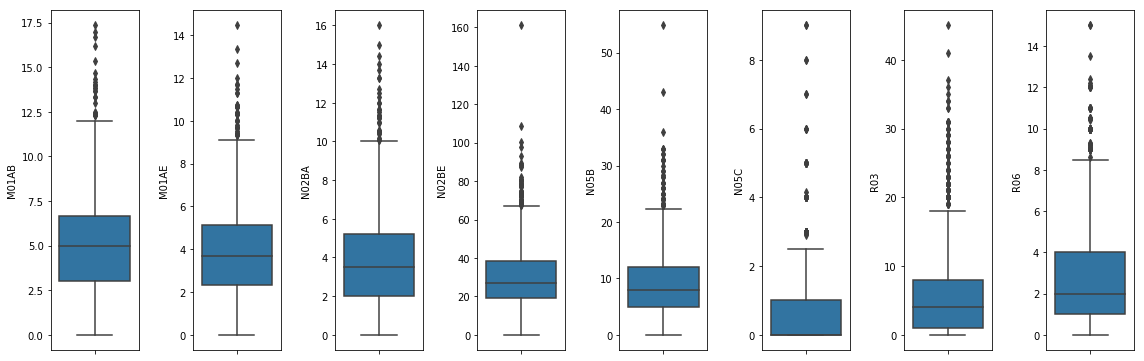

In [4]:
columns = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

number_of_columns = len(columns)
plt.figure(figsize=(2*number_of_columns,10))
for category in range(0,number_of_columns):
    plt.subplot(2 ,number_of_columns ,category+1)
    sns.boxplot(df[columns[category]], orient='v')
    plt.tight_layout()

Look at that! All of them includes outliers.<br>
In accordance with statistics, outliers are defined how values those out of 3 IQR.

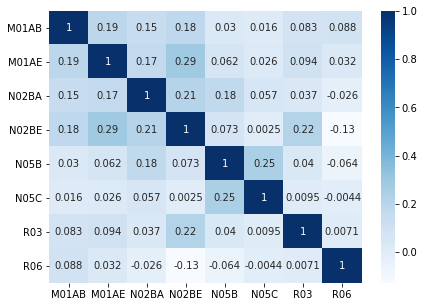

In [10]:
# calculate and show the correlation matrix for categories above
corr = df[cols].corr()
plt.figure(figsize = (7,5))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True, cmap='Blues');

As part of exploratory data analysis sometimes incredibly useful to look at correlation matrix to future models tuning or further data exploration. <br>
On the graph above dark shades represents positive correlation while lighter shades negative.
If you for instance desire use a linear regression, you have to consider a remove correlated variables with aim to improving forecast accuracy. <br>
In our case we can see lightly correlation between related categories (N05B, N05C and N02BA, N02BE) and interesting assotiation between M01AE, N02BA codes. Defining the reasons of that could be goal of further analysis.

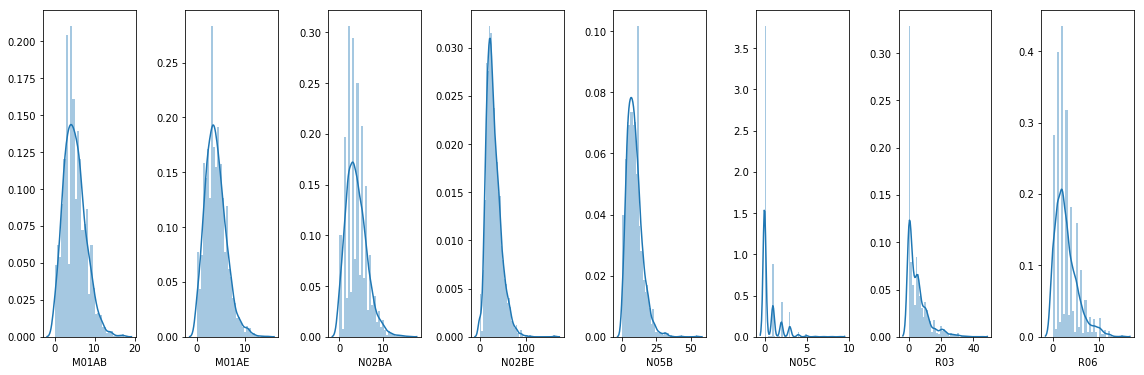

In [177]:
plt.figure(figsize=(2*number_of_columns,10))
for category in range(0,number_of_columns):
    plt.subplot(2 ,number_of_columns ,category+1)
    sns.distplot(df[columns[category]], kde=True)
    plt.tight_layout()

Here we see how data is distributed and what are most popular values for each independent categories. <br>
Also, we can see M01AB and M01AE seems like normally distributed. In the same time remaining codes are left skewed.

#### So, let's build up a time series prediction models

In [5]:
#Gathering ATC codes by types of category
atc_codes = {'Antirheumatic' : ['M01AB','M01AE'],
             'Analgesics' : ['N02BA','N02BE'],
             'Psycholeptics' : ['N05C','N05B'],
             'Airway diseases': ['R03'],
             'Antihistamines': ['R06']}

In [6]:
#Create function that will helps us to explore a sales dynamic
def create_charts(data, markets, title, index, freq):
    
    'Creates line chart with time defined frequency by markets'
    
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15,5))
    for codes in markets:
        ax.set_title('{} market'.format(title))
        index = data[codes].resample(freq).sum().index
        plt.plot(index, data[codes].resample(freq).sum())
        register_matplotlib_converters()
        plt.legend();

In [7]:
#Convert a column with dates in pandas daytime format
df['datum'] = pd.to_datetime(df['datum'])
df = df.set_index('datum')

#### Now we are ready to observe how sales changes

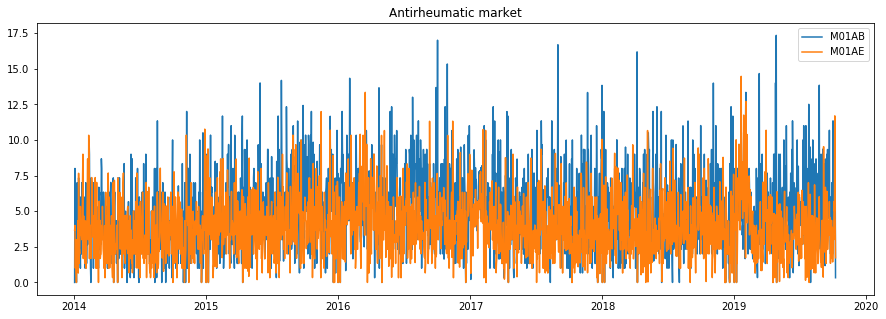

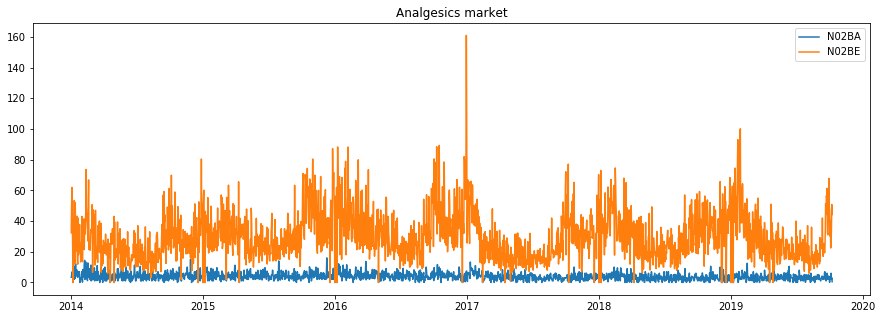

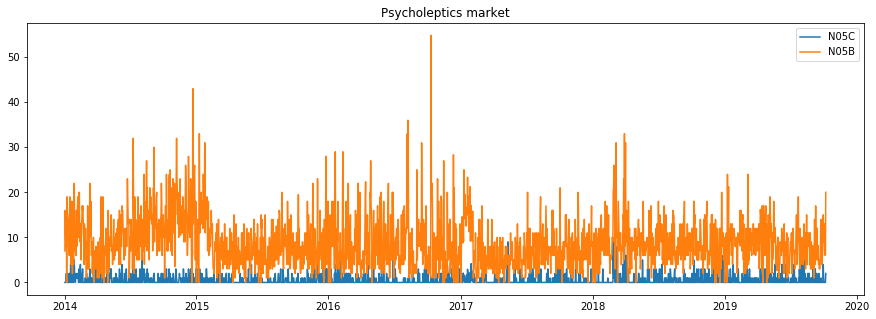

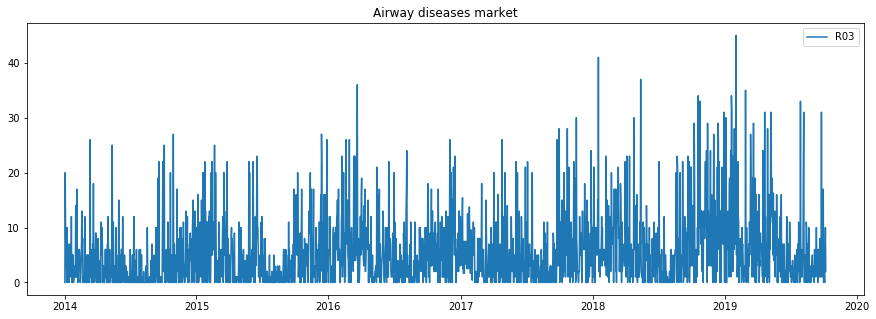

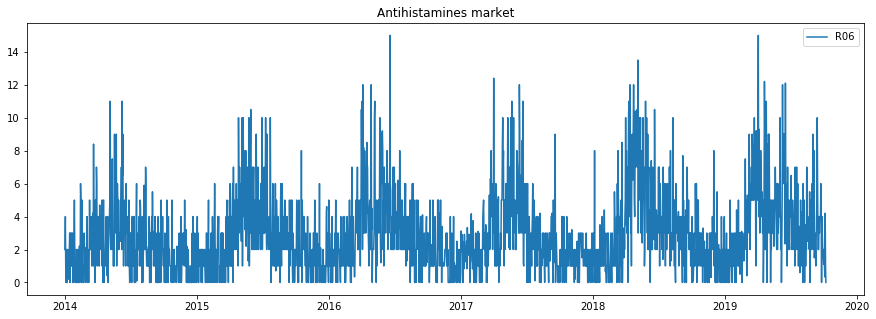

In [9]:
#Use predefined above function to explore sales dynamic
for market in atc_codes.items():
    create_charts(df, market[1], market[0], df.index, 'D')

Easy to see a clear seasonality of sales of antihistamines and analgesics products.<br>
Also, on the first sight, sales of antirheumatic drugs can seems a quite stationary <br>
However, let's look at monthly sales, without typical for daily data noise

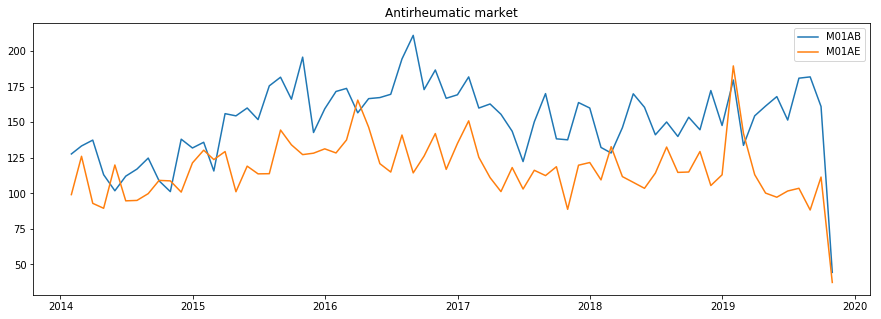

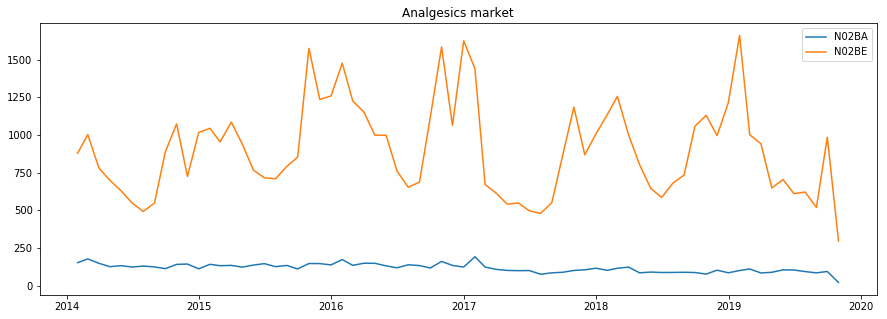

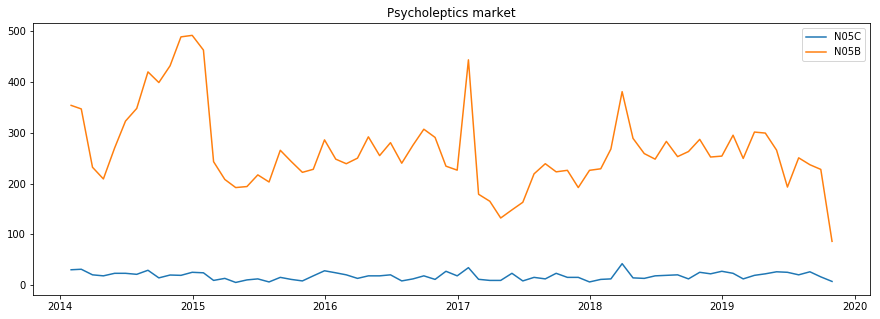

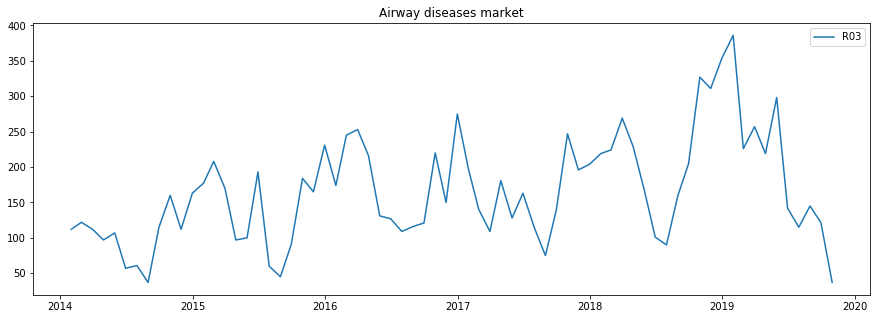

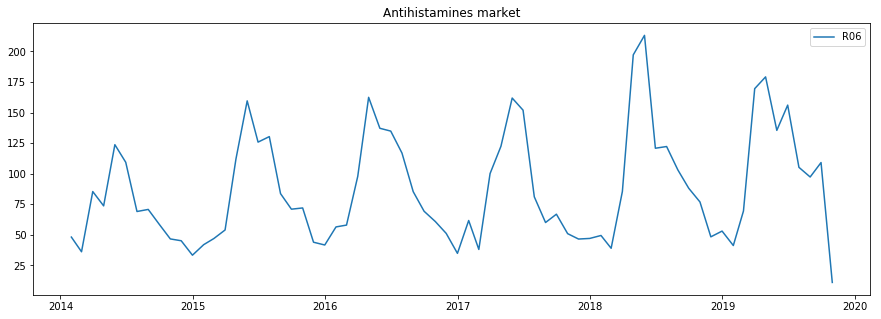

In [219]:
#Fo that we use the same function, but with changed type of frequency
for market in atc_codes.items():
    create_charts(df, market[1], market[0], df.index, 'M')

Great! Now data is much more readable and we can see that all of the markets except one have a seasonality<br>
You also can notice an increasing amount of sales during 2015 year on psycholeptics market and sharp decline then<br>
Sales of the airway disease market except seasonality includes an improving trend



### For the further steps and prediction modeling let's choose one market

In [10]:
#Select the Analgesics market for next steps
data = df[atc_codes['Analgesics']].copy()
data = data.set_index(df.index)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2014-01-02 to 2019-10-08
Data columns (total 2 columns):
N02BA    2106 non-null float64
N02BE    2106 non-null float64
dtypes: float64(2)
memory usage: 49.4 KB


In [12]:
#Combine ATC codes related to the same market in one
data['volume_sales'] = data['N02BA'] + data['N02BE']
data = data.drop(columns=['N02BA', 'N02BE'])

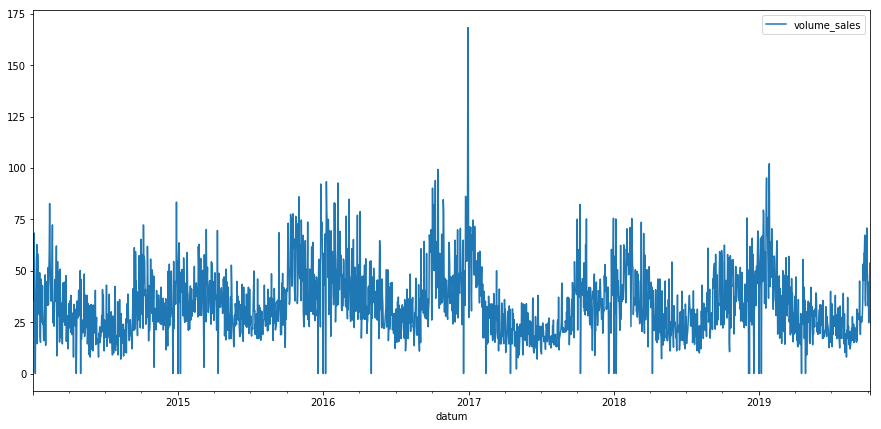

In [13]:
data.plot(figsize=(15,7))

In [75]:
#Split data for 2 independent groups. The first one we will use to models training and second one as test
# df_train = data[:'12/31/2018'].copy()
df_train = data['01/01/2017':'12/31/2018'].copy()
df_test = data['1/1/2019':].copy()

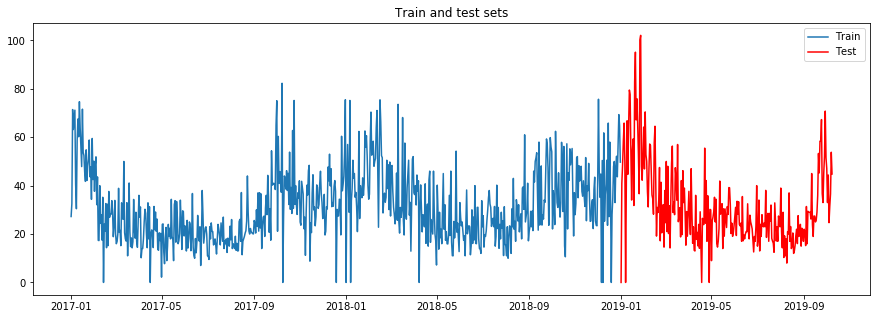

In [17]:
#Let's looks on those
plt.figure(figsize=(15,5))
plt.plot(df_train.index, df_train['volume_sales'], label='Train')
plt.plot(df_test.index, df_test['volume_sales'], color='r', label='Test')
plt.legend()
plt.title('Train and test sets')
register_matplotlib_converters()
plt.show()

We have to create some functions to generate features those we will us as predictors inside our's models. <br>
Pay your attention there are functions creates dummi features for a day time marks and one to scaled predictors

In [18]:
def linreg(X):
    
    n = X.shape[0]
    x = np.concatenate((np.ones(n),
                        np.arange(n)),
                      ).reshape(2, n).T
    
    y = X.reshape(-1,1)
    theta = np.linalg.pinv(x.dot(x.T)).dot(x).T.dot(y)

    return np.array([[1, n]]).dot(theta)

In [19]:
def create_features(data, lags_list):
    
    X = pd.DataFrame(data.values.ravel(), index=data.index, columns=['y'])
    
    for window in lags_list:
        X['lin_reg_{}'.format(window)] = X['y'].shift(1).rolling(window=window).apply(linreg, raw=True)
        X['shift_{}'.format(window)] = X['y'].shift(window)
        X['diff_{}'.format(window)] = X['y'].shift(1).diff(window)
        X['rolling_mean_{}'.format(window)] = X['y'].shift(1).rolling(window=window).mean()
        X['rolling_max_{}'.format(window)] = X['y'].shift(1).rolling(window=window).max()
        X['rolling_std_{}'.format(window)] = X['y'].shift(1).rolling(window=window).std()
        X['rolling_min_{}'.format(window)] = X['y'].shift(1).rolling(window=window).min()
        
    X = X.fillna(np.nanmedian(X))
    
    return X.drop('y', axis=1)

In [20]:
def create_dummies(data):
    
    X = pd.DataFrame({'day_of_week' : data.index.weekday_name}, data.index)
    days = pd.get_dummies(X['day_of_week'])
    result = pd.concat([data, days], axis=1, sort=False)
    
    return result

In [21]:
def scaler(data):
    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    result = pd.DataFrame(scaled, columns=[data.columns], index=data.index)
    
    return result

In [22]:
lags = [2,7,14]
X_train = scaler(create_dummies(create_features(df_train, lags)))

In [23]:
model_ridge = Ridge()
model_lasso = Lasso()
model_tree = DecisionTreeRegressor()
model_forest = RandomForestRegressor()
models = {'forest': model_forest,
          'lasso': model_lasso,
          'ridge': model_ridge,
          'tree': model_tree}

In [ ]:
# --------------

In [76]:
df_train.describe()

,volume_sales
count,730.000000
mean,31.372364
std,14.893961
min,0.000000
25%,20.325000
50%,29.000000
75%,40.200000
max,82.300000


In [77]:
train_data, fitted_lambda = stats.boxcox(df_train.volume_sales + 0.1)

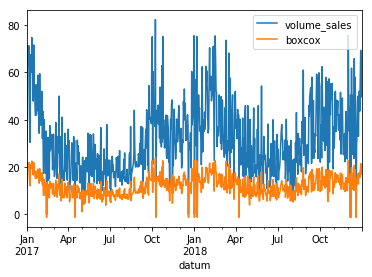

In [78]:
df_train['boxcox'] = train_data
df_train.plot()

In [63]:
df_train.drop(columns='volume_sales', inplace=True)

In [ ]:
# transform training data & save lambda value
train_data,fitted_lambda = stats.boxcox(train)

# use lambda value to transform test data
test_data = stats.boxcox(test, fitted_lambda)

In [84]:
df_train.head()

,volume_sales,boxcox
datum,,
2017-01-01,27.237500,11.207099
2017-01-02,32.625000,12.745648
2017-01-03,71.437500,21.896307
2017-01-04,63.183333,20.147188
2017-01-05,67.416667,21.054123


In [83]:
inv_boxcox(train_data, fitted_lambda)

array([27.3375    , 32.725     , 71.5375    , 63.28333334, 67.51666666,
       71.2875    , 40.68333333, 30.55833333, 58.80833333, 67.64166667,
       60.30833334, 74.7875    , 64.05833334, 55.725     , 47.975     ,
       71.70416667, 53.85      , 52.55833333, 45.68333333, 41.85      ,
       54.89166666, 42.24583333, 48.14166667, 51.14166666, 58.95416667,
       43.76666667, 47.87583334, 34.43333333, 59.6       , 42.6175    ,
       50.18333333, 37.76666667, 48.80833334, 52.00083333, 32.225     ,
       43.7       , 17.5       , 17.4       , 40.1       , 24.5       ,
       28.05      , 17.6       , 35.3       ,  0.1       , 24.2       ,
       21.3       , 32.7       , 14.45      , 32.45      , 15.3       ,
       37.7       , 27.        , 28.4       , 28.25      , 33.9       ,
       29.35      , 19.        , 23.5       , 34.        , 20.2       ,
       16.1       , 17.        , 20.2       , 39.        , 20.8       ,
       21.6       , 15.3       , 33.        , 31.        , 26.2 

array([11.20709938, 12.74564821, 21.89630685, 20.14718759, 21.05412255])

In [65]:
def train(X, actual, model, n_splits=10):
    
    cv = TimeSeriesSplit(n_splits=n_splits)
    y = []
    i = 0 

    for train, test in cv.split(X):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = actual[train], actual[test]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if i == 0:
            y.extend(model.predict(X_train))
        i+=1
        y.extend(y_pred)
        
    return y

In [66]:
df = pd.DataFrame()
for model in models.items():
    df[model[0]] = train(X_train, df_train.values.ravel(), model[1])

In [26]:
def model_to_chart(y, y_pred, model_name, index):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15,5))
    ax.set_title('Model:{}, MAE = {:.3f}'.format(model_name, mean_absolute_error(y, y_pred)))
    plt.plot(index, y, label='True')
    plt.plot(index, y_pred, label='Predicted')
    plt.plot(index, y - y_pred, label='error', alpha=.3)
    plt.legend()
    register_matplotlib_converters();

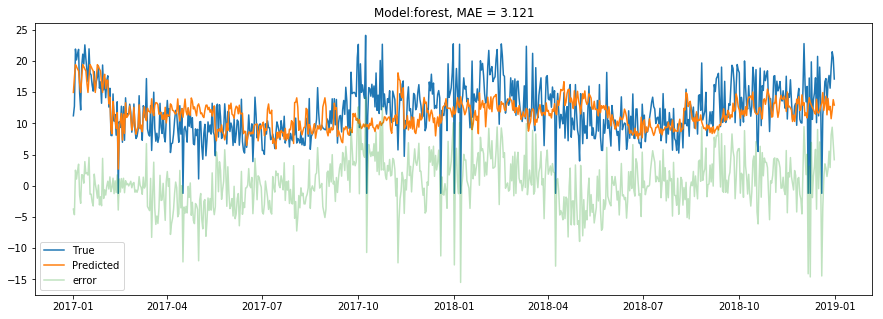

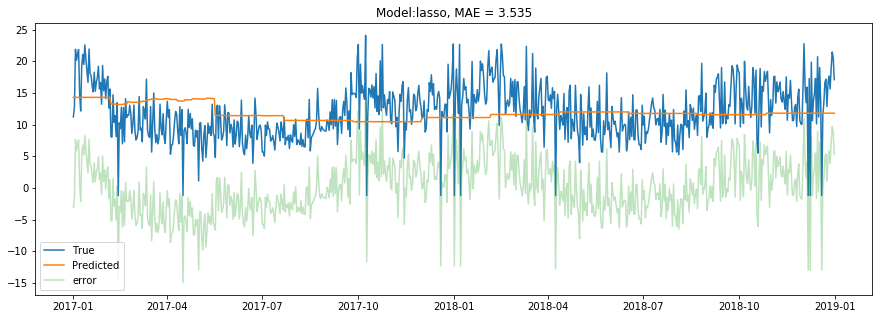

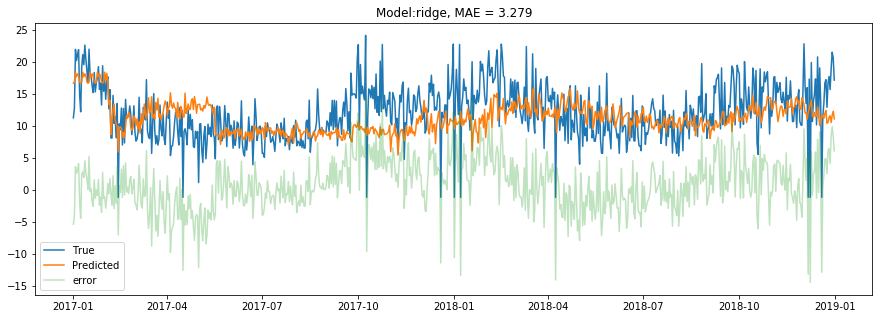

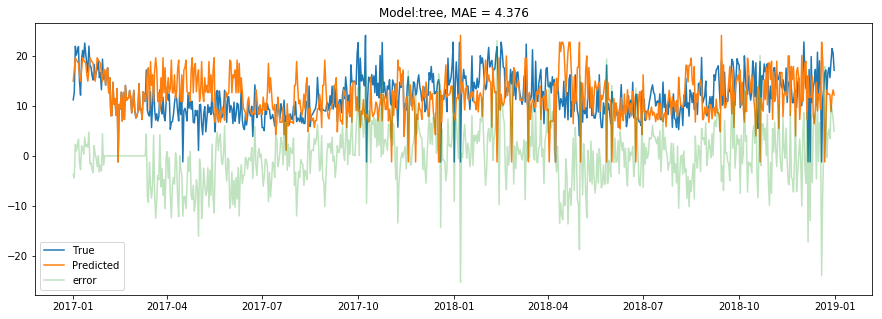

In [68]:
#Посмотрим что получается на трейне
for model in models.items():
    model_to_chart(y=df_train[:3000].values.ravel(), 
                y_pred= df[:3000][model[0]].values, 
                index = df_train[:3000].index, 
                model_name=model[0])

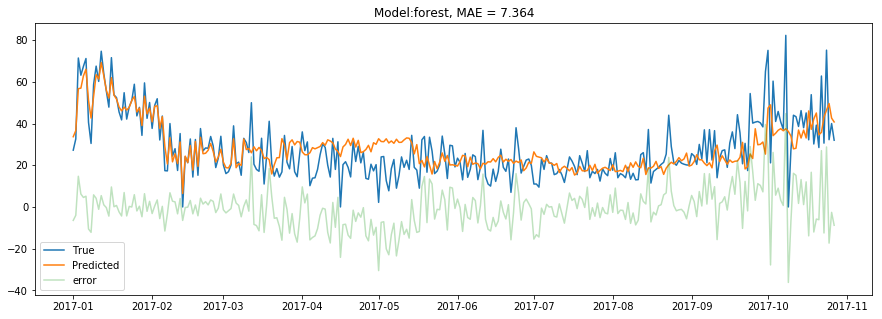

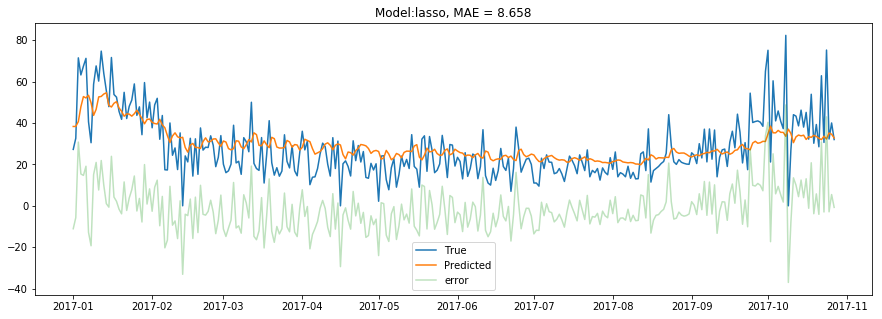

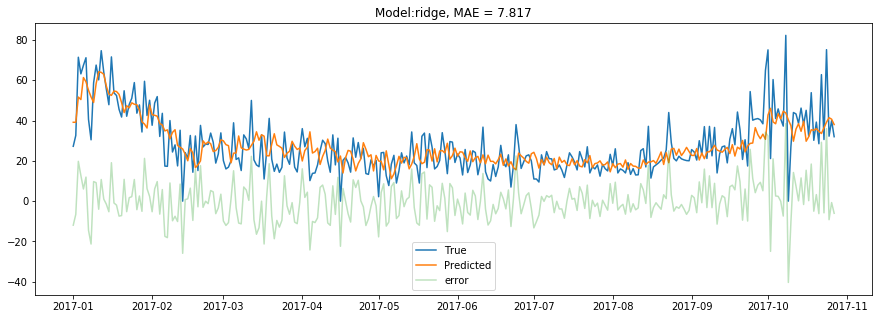

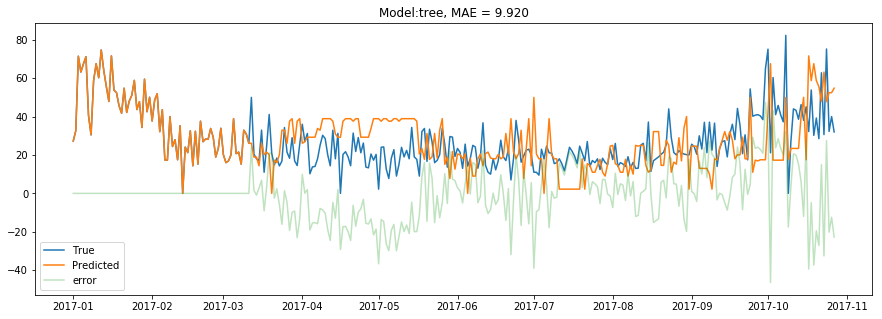

In [27]:
#Посмотрим что получается на трейне
for model in models.items():
    model_to_chart(y=df_train[:300].values.ravel(), 
                y_pred= df[:300][model[0]].values, 
                index = df_train[:300].index, 
                model_name=model[0])

Стратегия 1 "Генерируем признаки для будущих значений из уже предсказанных"<br>
Помните что мы предсказываем на 24 тайм степов вперед, поэтому для генерации некоторых признаков у нас нет значений временного ряда $y_t$. <br>
Вместо них мы будем использовать свои предсказания $\hat{y}_t$.

In [28]:
def create_dates(data, n_steps_prediction):
    
    'Функция создает ровно 1 день от последней даты'
    
    start_date = data.index[-1] + pd.DateOffset(1) #определяем последнюю дату в дата сете
    new_date = pd.date_range(start_date, periods=n_steps_prediction) #создаем дата сет с датами
    
    return data.append(pd.DataFrame(index=new_date), sort=True)#добавляем новые даты к основному датасету

In [32]:
def forecast_maker(models, data, n_steps, lags_list):
    
    'Функция просит на вход df с датами в части индексов и минимум 16 значениями из трейна для формирования фичей'
    
    df = create_dates(data, n_steps) #создаем новые даты
    
    for model in models.items(): #итерируемся по всем моделям
        
        df[model[0]] = df.values[:,0] #передаем из основного датасета факты для генерациии первоначальных фичей

        for i in range(0, n_steps-1):
            x_features = scaler(create_dummies(create_features(df[model[0]], lags_list=lags_list))) #генерируем фичи и шкалируем 
            y_pred = np.round(model[1].predict(x_features.iloc[-n_steps+i:-n_steps+i+1]), 2) #предсказывает новое значение
            
            df[model[0]].iloc[-n_steps+i] = y_pred #добавляет новое значение в df для соответствующей модели
        
    return df

In [30]:
# Для генерации фичей я буду использовать тот же дата фрейм, на котором тренировались 


In [33]:
predicted_values = forecast_maker(models = models, data=df_train, n_steps=30, lags_list=lags)

In [34]:
predicted_values.drop(axis=1, columns='volume_sales', inplace=True)

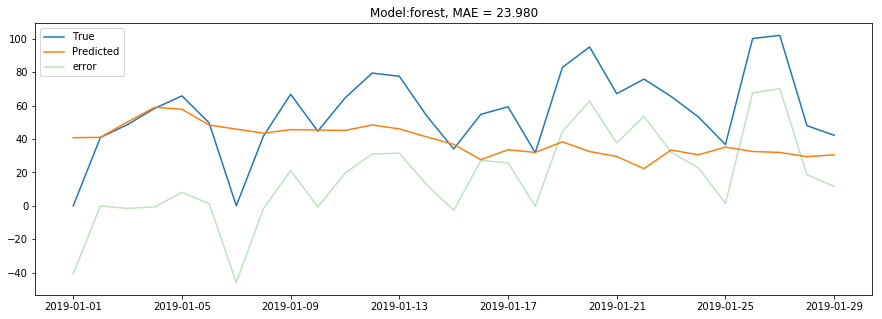

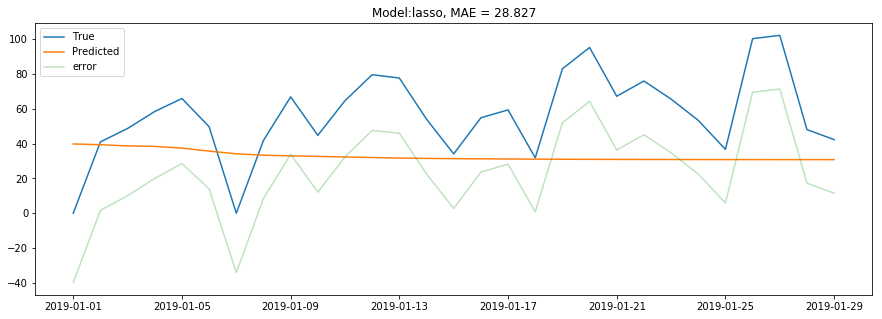

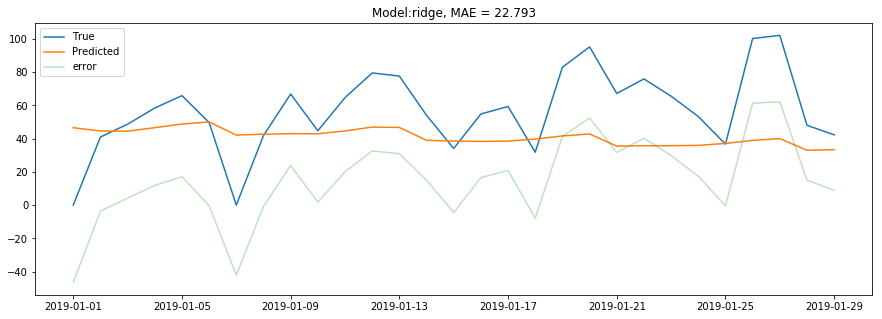

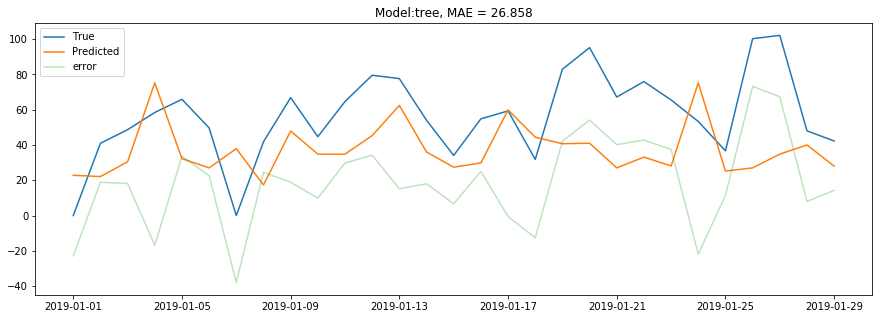

In [35]:
for model in models.items():
    model_to_chart(y=df_test.loc[:'2019-01-29'].values.ravel(), 
                y_pred= predicted_values.iloc[-30:-1][model[0]].values, 
                index = predicted_values.iloc[-30:-1].index, 
                model_name=model[0])

Предсказание на K тактов вперед. </br>
Если предсказательный горизонт P меньше K, то все признаки можно генерить из истинных значений временного ряда.

In [36]:
model_ridge_K = Ridge()
model_lasso_K = Lasso()
model_tree_K = DecisionTreeRegressor()
model_forest_K = RandomForestRegressor()
models_K = {'forest': model_forest_K,
          'lasso': model_lasso_K,
          'ridge': model_ridge_K,
          'tree': model_tree_K}

In [37]:
def create_features_K(data, windows, lag_start, lag_end):
    
    X = pd.DataFrame(data.values.ravel(), index=data.index, columns=['y'])
    
    for i in range(lag_start, lag_end):
        
        X['shift_{}'.format(i)] = X['y'].shift(i) 
    
    for window in windows:
    
        X['lin_reg_{}'.format(window)] = X['y'].shift(lag_start).rolling(window=window).apply(linreg, raw=True)
        X['diff_{}'.format(window)] = X['y'].shift(lag_start).diff(window)
        X['rolling_mean_{}'.format(window)] = X['y'].shift(lag_start).rolling(window=window).mean() #сдвигаем на lag_start и берем среднее из окна в размер window
        X['rolling_max_{}'.format(window)] = X['y'].shift(lag_start).rolling(window=window).max()
        X['rolling_std_{}'.format(window)] = X['y'].shift(lag_start).rolling(window=window).std()
        X['rolling_min_{}'.format(window)] = X['y'].shift(lag_start).rolling(window=window).min()
        
    X = X.fillna(np.nanmedian(X))
    
    return X.drop('y', axis=1)

In [38]:
X_train = scaler(create_dummies(create_features_K(df_train, lags, lag_start=30, lag_end=40)))

In [39]:
df = pd.DataFrame()
for model in models_K.items():
    df[model[0]] = train(X_train, df_train.values.ravel(), model[1])

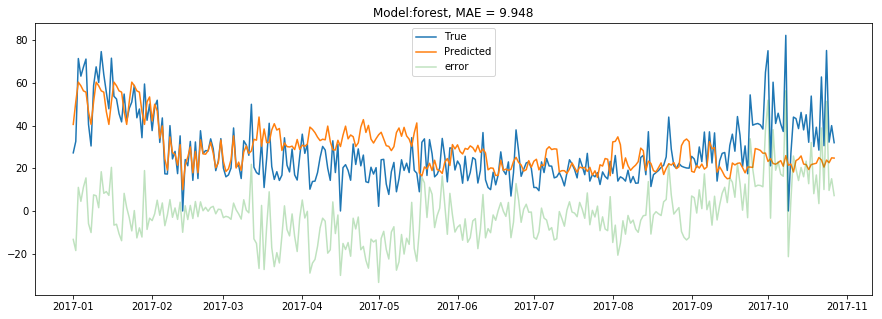

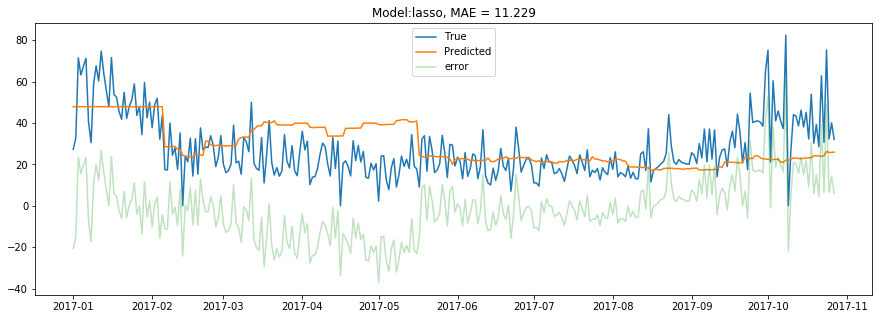

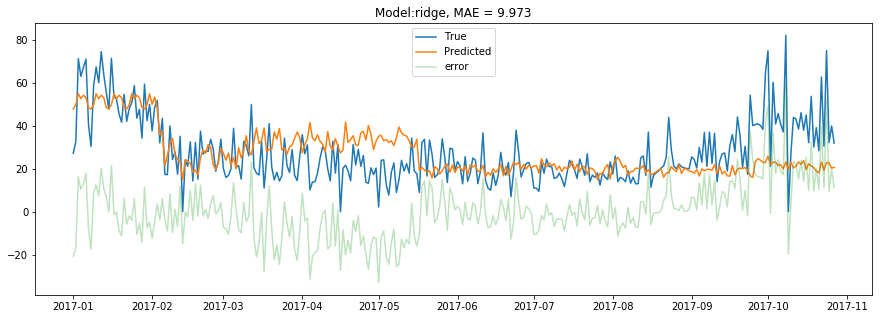

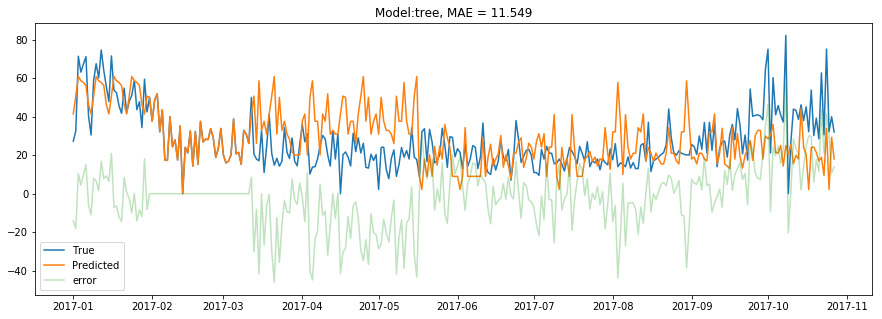

In [40]:
#Посмотрим что получается на трейне
for model in models_K.items():
    model_to_chart(y=df_train[:300].values.ravel(), 
                y_pred= df[:300][model[0]].values, 
                index = df_train[:300].index, 
                model_name=model[0])

In [41]:
def forecast_maker_K(models, data, n_steps, windows, lag_start, lag_end):
    
    'Функция просит на вход df с датами в части индексов и минимум 16 значениями из трейна для формирования фичей'
    
#     df = create_dates(data, n_steps) #создаем новые даты
    
    x_features = scaler(create_dummies(create_features_K(create_dates(data, n_steps), windows, lag_start, lag_end)))
    
    df = pd.DataFrame(index=x_features.iloc[-n_steps:].index)
    
    for model in models.items(): #итерируемся по всем моделям
        
        df[model[0]] = np.nan
        df[model[0]] = model[1].predict(x_features.iloc[-n_steps:])
        
    return df

In [42]:
predicted_values_K = forecast_maker_K(models_K, df_train, n_steps=30, windows=lags, lag_start=30, lag_end=40)

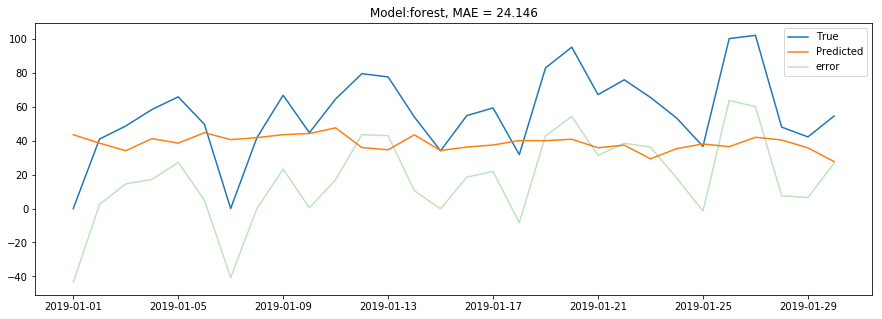

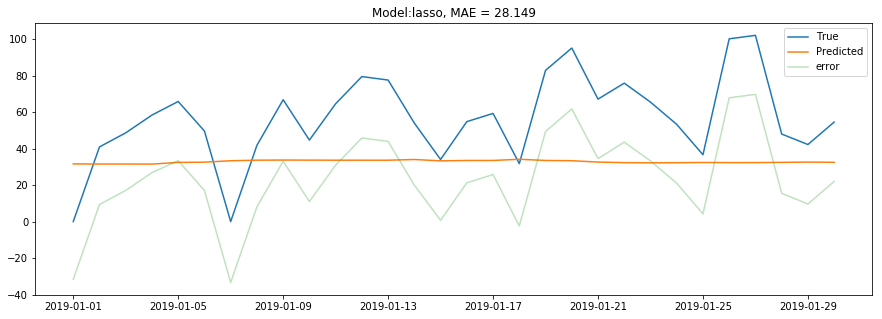

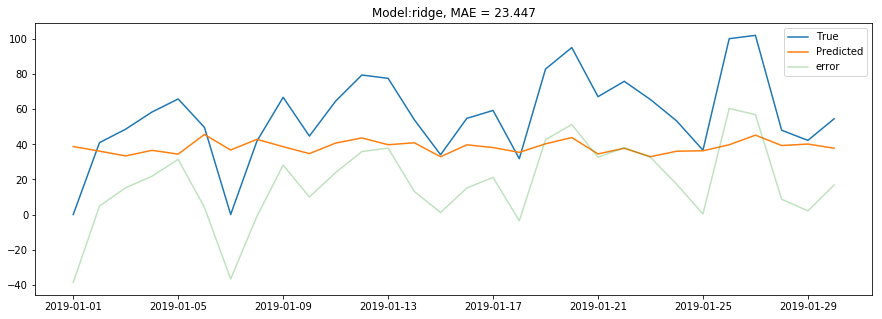

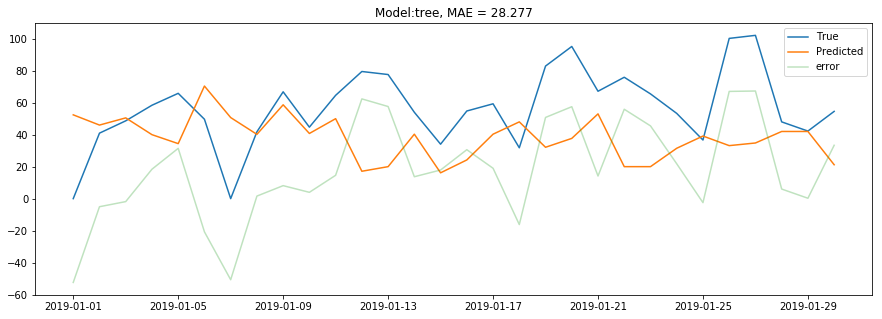

In [43]:
for model in models_K.items():
    model_to_chart(y=df_test.loc[:'2019-01-30'].values.ravel(), 
                y_pred= predicted_values_K[model[0]].values, 
                index = predicted_values_K.index, 
                model_name=model[0])

## P.S. Третий способ.

На самом деле вы можете создавать индивидуальные модели для предсказания на K шагов вперед:<br>
- отдельная модель для предсказания на 1 шаг вперд <br>
- отдельная модель для предсказания на 2 шага вперед <br>
- и так далее.



In [111]:
def forecast_maker_combo(models, models_K, data, first_stage, second_stage, windows, lag_end):
    
    x_features_K = scaler(create_dummies(create_features_K(create_dates(data, first_stage+second_stage), windows, first_stage, lag_end)))
    df = pd.DataFrame(index=x_features_K.iloc[-(first_stage+second_stage):].index)

    
    for model in models_K.items(): #итерируемся по всем моделям
        
        df[model[0]] = np.nan

        df[model[0]].iloc[:first_stage] = model[1].predict(x_features_K.iloc[-first_stage:])
        
        for i in range(0, second_stage-1):
            
            x_features = scaler(create_dummies(create_features(df[model[0]], lags_list=windows, test=True))) #генерируем фичи и шкалируем 
            y_pred = np.round(models[model[0]].predict(x_features.iloc[-second_stage+i:-second_stage+i+1]), 2) #предсказывает новое значение
            
            df[model[0]].iloc[-second_stage+i] = y_pred #добавляет новое значение в df для соответствующей модели
        
    return df

In [112]:
predicted_values_combo = forecast_maker_combo(models, models_K, df_train, first_stage=20, second_stage=10, windows=lags,  lag_end=30)

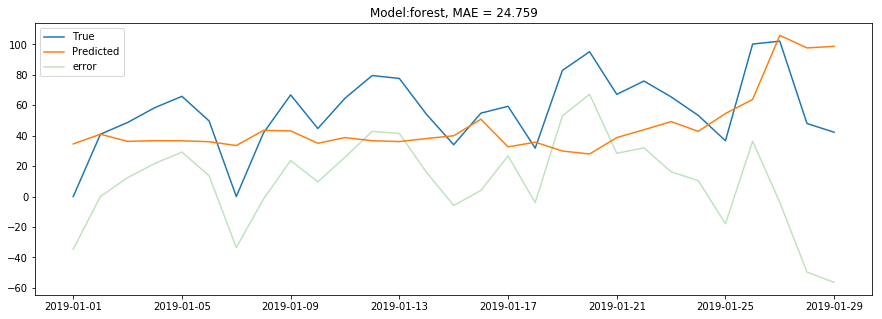

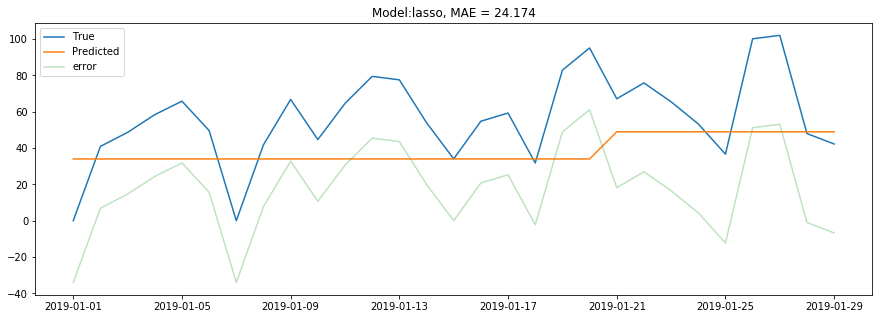

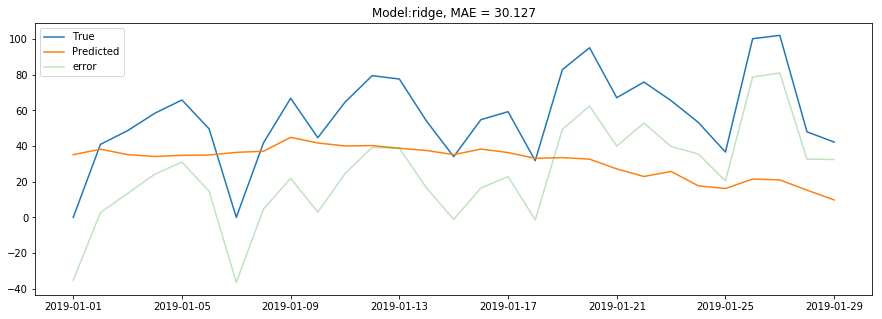

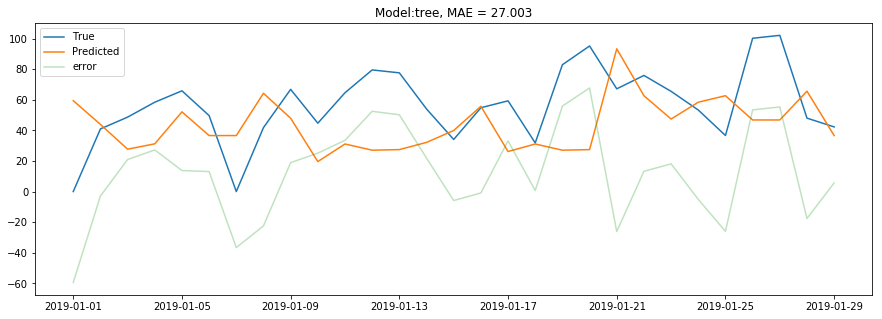

In [117]:
for model in models_K.items():
    model_to_chart(y=df_test.loc[:'2019-01-29'].values.ravel(), 
                y_pred= predicted_values_combo[model[0]].iloc[:-1].values, 
                index = predicted_values_combo.iloc[:-1].index, 
                model_name=model[0])